In [21]:
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import sklearn
import numpy as np
from imutils import paths
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import scipy

In [3]:
print(tf.__version__)
init_lr = 0.001
epochs = 25
batch_size = 8

2.2.0


In [4]:
print('Loading Images...')
imagePaths = list(paths.list_images("/home/nvkanirudh/keras_XRay_Covid/NvkAnirudh/dataset"))
data = []
labels = []

Loading Images...


In [5]:
for imagePath in imagePaths:
    label = imagePath.split("/")[-2]
    
    image = cv2.imread(imagePath)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224,224))    
    
    data.append(image)
    labels.append(label)

data = np.array(data) / 255.0
labels = np.array(labels)

In [6]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [7]:
train_X, test_X, train_y, test_y = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

trainAug = ImageDataGenerator(rotation_range=15, fill_mode="nearest")

In [8]:
baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224,224,3)))

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

for layer in baseModel.layers:
    layer.trainable=False

In [9]:
import scipy
print("Compiling model...")
opt = Adam(lr=init_lr, decay=init_lr/epochs)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

print("Training head...")
train = model.fit(x=trainAug.flow(train_X, train_y, batch_size=batch_size),
                 steps_per_epoch=len(train_X)//batch_size,
                 validation_data = (test_X, test_y),
                 epochs=epochs)

Compiling model...
Training head...
Epoch 1/25
5/5 [==============================] - 8s 2s/step - loss: 0.8091 - accuracy: 0.5000 - val_loss: 0.6739 - val_accuracy: 0.5000
Epoch 2/25
5/5 [==============================] - 7s 1s/step - loss: 0.7328 - accuracy: 0.5000 - val_loss: 0.6414 - val_accuracy: 0.5000
Epoch 3/25
5/5 [==============================] - 7s 1s/step - loss: 0.7577 - accuracy: 0.4750 - val_loss: 0.6425 - val_accuracy: 0.5000
Epoch 4/25
5/5 [==============================] - 6s 1s/step - loss: 0.5797 - accuracy: 0.7000 - val_loss: 0.6099 - val_accuracy: 0.7000
Epoch 5/25
5/5 [==============================] - 6s 1s/step - loss: 0.6254 - accuracy: 0.6000 - val_loss: 0.5976 - val_accuracy: 0.7000
Epoch 6/25
5/5 [==============================] - 6s 1s/step - loss: 0.7494 - accuracy: 0.5750 - val_loss: 0.5946 - val_accuracy: 0.5000
Epoch 7/25
5/5 [==============================] - 7s 1s/step - loss: 0.6745 - accuracy: 0.6000 - val_loss: 0.5625 - val_accuracy: 0.8000
Epoch

In [11]:
print("Evaluating model...")
predIndices = model.predict(test_X, batch_size=batch_size)
print(predIndices)
predIndices = np.argmax(predIndices, axis=1)
print(predIndices)

Evaluating model...
[[0.3102216  0.68977845]
 [0.22161889 0.7783811 ]
 [0.5182898  0.48171017]
 [0.19836639 0.80163366]
 [0.7490196  0.2509804 ]
 [0.88923156 0.11076839]
 [0.7160252  0.28397483]
 [0.8422935  0.1577065 ]
 [0.4887918  0.51120824]
 [0.80364305 0.19635692]]
[1 1 0 1 0 0 0 0 1 0]


In [18]:
print(classification_report(test_y.argmax(axis=1), predIndices, target_names=lb.classes_))

              precision    recall  f1-score   support

       covid       0.83      1.00      0.91         5
      normal       1.00      0.80      0.89         5

    accuracy                           0.90        10
   macro avg       0.92      0.90      0.90        10
weighted avg       0.92      0.90      0.90        10

[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]


In [25]:
print(confusion_matrix(test_y.argmax(axis=1), predIndices))
print("Precision: ",precision_score(test_y.argmax(axis=1), predIndices))
print("Recall: ",recall_score(test_y.argmax(axis=1), predIndices))



[[5 0]
 [1 4]]
Precision:  1.0
Recall:  0.8


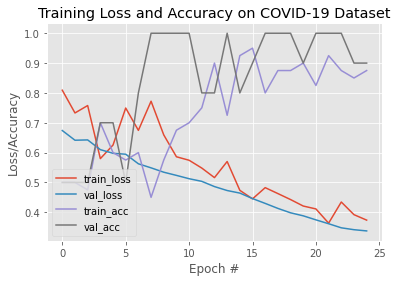

In [31]:
N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), train.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), train.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), train.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), train.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("/home/nvkanirudh/keras_XRay_Covid/NvkAnirudh/plot")

In [32]:
print("[INFO] saving COVID-19 detector model...")
model.save("/home/nvkanirudh/keras_XRay_Covid/NvkAnirudh/model", save_format="h5")

[INFO] saving COVID-19 detector model...
